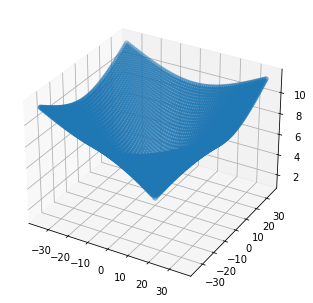

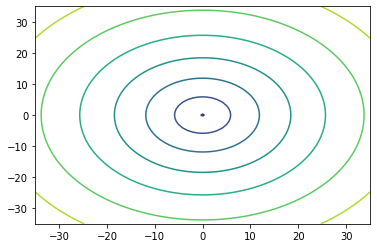

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def ackley(X, Y):
    Z = np.zeros((len(X), len(Y)))
    
    factor_1 = -0.02 * np.sqrt(0.5 * (X * X + Y * Y))
    factor_2 = 0.5 * (np.cos(2 * np.pi * X + np.cos(2 * np.pi * Y)))
    
    Z = -20 * np.exp(factor_1) - np.exp(factor_2) + np.exp(1) + 20

    return Z

def plot_ackley (X, Y, Z):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(X, Y, Z, label='Ackley Function')
    plt.show()

def plot_ackley_contour (X, Y, Z):
    ax = plt.axes()
    ax.contour(X, Y, Z)

wek_x = np.arange(-35,36,1)
wek_y = np.arange(-35,36,1)

X, Y = np.meshgrid(wek_x, wek_y)

Z = ackley(X, Y)

plot_ackley(X, Y, Z)

plot_ackley_contour(X, Y, Z)